In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

from architectures.CNN import *

In [2]:
# some constants

LEARNING_RATE = 0.009
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 10
SAVE_SAMPLE_PERIOD = 1
PATH='CNN_test'

#task='TRAIN'
task='TEST'
SEED=1


In [3]:
trunc_normal= tf.truncated_normal_initializer(stddev=1, seed=SEED)
normal = tf.random_normal_initializer(stddev=1, seed=SEED)
uniform = tf.random_uniform_initializer(seed=SEED)

global sizes
sizes = {
        'conv_layer_0': [(8, 8, 2, False, 0.6, lrelu, normal)],
        'maxpool_layer_0':[(4, 2, 1)],
        'conv_layer_1':[(16, 6, 2, False, 0.6, lrelu, normal)],
        'conv_layer_2':[(32, 4, 2, 'bn', 0.6, lrelu, normal)],
        'maxpool_layer_1':[(2, 2, 1)],
        'dense_layers':[(512, 'bn', 0.8, tf.nn.relu, normal),
                       (64, 'bn', 0.8, tf.nn.relu, normal),
                       (32, False, 0.8, tf.nn.relu, normal)],
        'n_classes':10,
        'readout_w_init':uniform
}

In [8]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

    X_train = mnist.train.images
    Y_train = mnist.train.labels
    
    X_train = X_train.reshape(len(X_train),28,28,1)
    Y_train = Y_train.reshape(len(Y_train),10)
    
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    Y_test = mnist.test.labels
    
    X_test = X_test.reshape(len(X_test),28,28,1)
    Y_test =  Y_test.reshape(len(Y_test),10)
    
    tf.reset_default_graph()
    cnn = CNN(n_H, n_W, n_C, sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            cnn.set_session(sess)
            cnn.fit(X_train, Y_train, X_test, Y_test)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            cnn.set_session(sess)   
        
        eval_seed=1   
        done = False
        while not done:
            
            np.random.seed(eval_seed)
            
            i = np.random.choice(len(X_test))
            
            x = X_test[i].reshape(X_test.shape[1],X_test.shape[2],X_test.shape[3])
            
            ground_truth=np.where(Y_test[i]>0)[0][0]
            p = cnn.predict([x]).reshape(sizes['n_classes'])
            prediction = np.where(p==np.max(p))[0][0]
            
            
            plt.clf()
            plt.imshow(x.reshape(
                                X_test.shape[1],
                                X_test.shape[2]),
                                cmap='gray'
                      )
            plt.title('Input image')
            plt.show()
            
            print('True class: '+str(ground_truth)+'\n'+
                  'Predicted class: '+str(prediction)+'\n')
                  
            
            eval_seed+=1
            ans = input("Predict another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolutional network architecture detected
Convolution
Input for convolution (?, 28, 28, 1)
Logits shape (?, 10)
Convolution
Input for convolution (?, 28, 28, 1)
Logits shape (?, 10)

 Evaluate model on test set...
INFO:tensorflow:Restoring parameters from CNN_test/CNN_test.ckpt
Model restored.


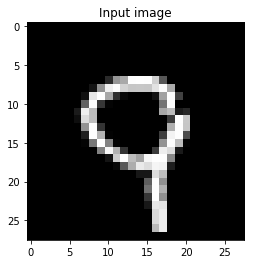

True class: 9
Predicted class: 9

Predict another?


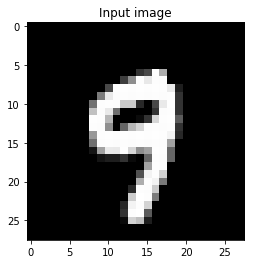

True class: 9
Predicted class: 9

Predict another?


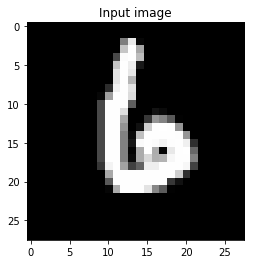

True class: 6
Predicted class: 6

Predict another?n


In [9]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()